<a href="https://colab.research.google.com/github/ndvp39/autoscope/blob/main/Training_AutoScope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Getting the dataset from the drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

import os
import shutil

base_dir = '/content/drive/MyDrive/AutoScope/DataSet4'

output_dir = '/content/sorted_dataset'
os.makedirs(output_dir, exist_ok=True)

categories = ["Infected", "Normal"]

for category in categories:
    os.makedirs(f"{output_dir}/train/{category}", exist_ok=True)
    os.makedirs(f"{output_dir}/validation/{category}", exist_ok=True)
    os.makedirs(f"{output_dir}/test/{category}", exist_ok=True)




Mounted at /content/drive


Data distribution for train, test and validation.

In [ ]:
import os
import shutil
import random

train_ = 0.6
validation_ = 0.25
# test_ = 1 - train_ - validation_

def split_data(category):
    category_path = os.path.join(base_dir, category)
    all_images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    random.shuffle(all_images) # Random image for each catagory

    num_images = len(all_images)
    num_train = int(num_images * train_)
    num_validation = int(num_images * validation_)
    num_test = num_images - num_train - num_validation

    for i, image in enumerate(all_images):
        image_path = os.path.join(category_path, image)
        if i < num_train:
            shutil.copy(image_path, f"{output_dir}/train/{category}/{image}")
        elif i < num_train + num_validation:
            shutil.copy(image_path, f"{output_dir}/validation/{category}/{image}")
        else:
            shutil.copy(image_path, f"{output_dir}/test/{category}/{image}")

for category in categories:
    split_data(category)

print(f"The dataset was successfully divided into: train ({round(train_*100)}%), test ({round((1 - validation_ - train_) * 100)}%), validation ({round(validation_*100)}%).")


The dataset was successfully divided into: train (60%), test (15%), validation (25%).


Counting the images

In [ ]:
import os

def count_images_in_dirs(base_dir, categories, subdirs=['train', 'validation', 'test']):
    for subdir in subdirs:
        print(f"\nCounting images in {subdir} directory:")
        for category in categories:
            category_path = os.path.join(base_dir, subdir, category)
            if os.path.exists(category_path):
                num_images = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])
                print(f"Category: {category}, Number of images: {num_images}")
            else:
                print(f"Category: {category} not found in {subdir} directory")

base_dir = '/content/sorted_dataset'

categories = ['Infected', 'Normal']

count_images_in_dirs(base_dir, categories)



Counting images in train directory:
Category: Infected, Number of images: 225
Category: Normal, Number of images: 376

Counting images in validation directory:
Category: Infected, Number of images: 115
Category: Normal, Number of images: 133

Counting images in test directory:
Category: Infected, Number of images: 73
Category: Normal, Number of images: 81


In [ ]:
import os

import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LeakyReLU
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input


datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input # resnet50 images preprocess
)

datagen_train = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input, # resnet50 images preprocess
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_generator = datagen_train.flow_from_directory(
    '/content/sorted_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    classes=['Normal', 'Infected']
)

validation_generator = datagen.flow_from_directory(
    '/content/sorted_dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    classes=['Normal', 'Infected']
)

test_generator = datagen.flow_from_directory(
    '/content/sorted_dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['Normal', 'Infected']
)


base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
for layer in base_model.layers[:-10]:
    layer.trainable = True


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)

predictions = Dense(1, activation="sigmoid")(x)



model = Model(inputs=base_model.input, outputs=predictions)
# optimizer = Adam(learning_rate=1e-4)
optimizer = SGD(learning_rate=1e-3, momentum=0.9)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

class_indices = train_generator.class_indices
print(class_indices)

# balance the weights in Infected and Normal images
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, min_lr=1e-6)
    ]
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test group accuracy: {test_accuracy * 100:.2f}%")


Found 601 images belonging to 2 classes.
Found 248 images belonging to 2 classes.
Found 154 images belonging to 2 classes.
{'Normal': 0, 'Infected': 1}
Class Weights: {0: 0.7992021276595744, 1: 1.3355555555555556}
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 559s 28s/step - accuracy: 0.5212 - loss: 0.7439 - val_accuracy: 0.5605 - val_loss: 0.7924 - learning_rate: 0.0010
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 568s 30s/step - accuracy: 0.6698 - loss: 0.6162 - val_accuracy: 0.6734 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 580s 28s/step - accuracy: 0.7089 - loss: 0.5524 - val_accuracy: 0.7581 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 560s 27s/step - accuracy: 0.7614 - loss: 0.5029 - val_accuracy: 0.7621 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 525s 27s/step - accuracy: 0.8231 - loss: 0.4609 - val_accuracy: 0.8024 - val_loss: 0.4432 - learning_rate: 0.0010
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 520s 27s/step - accuracy: 0.8501 - loss: 0.3721 - val_accuracy: 0.7500 - val_loss: 0.4780 - learning_rate: 0.0010
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 563s 27s/step - accuracy: 0.8699 - loss: 0.3049 - val_accurac

In [ ]:
import json

def save_history_to_json(history, file_path="training_history.json"):
    """
    Save training history to a JSON file.

    Parameters:
    - history: The training history object from the model.
    - file_path: The path to save the JSON file (default: "training_history.json").
    """
    history_dict = history.history  # Extract the history dictionary
    with open(file_path, 'w') as json_file:
        json.dump(history_dict, json_file, indent=4)
    print(f"Training history saved to {file_path}")
save_history_to_json(history, "training_history.json")


Training history saved to training_history.json


In [ ]:
def load_history_from_json(file_path="training_history.json"):
    """
    Load training history from a JSON file.

    Parameters:
    - file_path: The path to the JSON file (default: "training_history.json").

    Returns:
    - history_dict: The loaded history dictionary.
    """
    with open(file_path, 'r') as json_file:
        history_dict = json.load(json_file)
    print(f"Training history loaded from {file_path}")
    return history_dict
history = load_history_from_json("training_history.json")


Display examples of original and preprocessed images from the test set, including true labels, predicted labels, and model confidence scores, to visualize how the model interprets the input data.

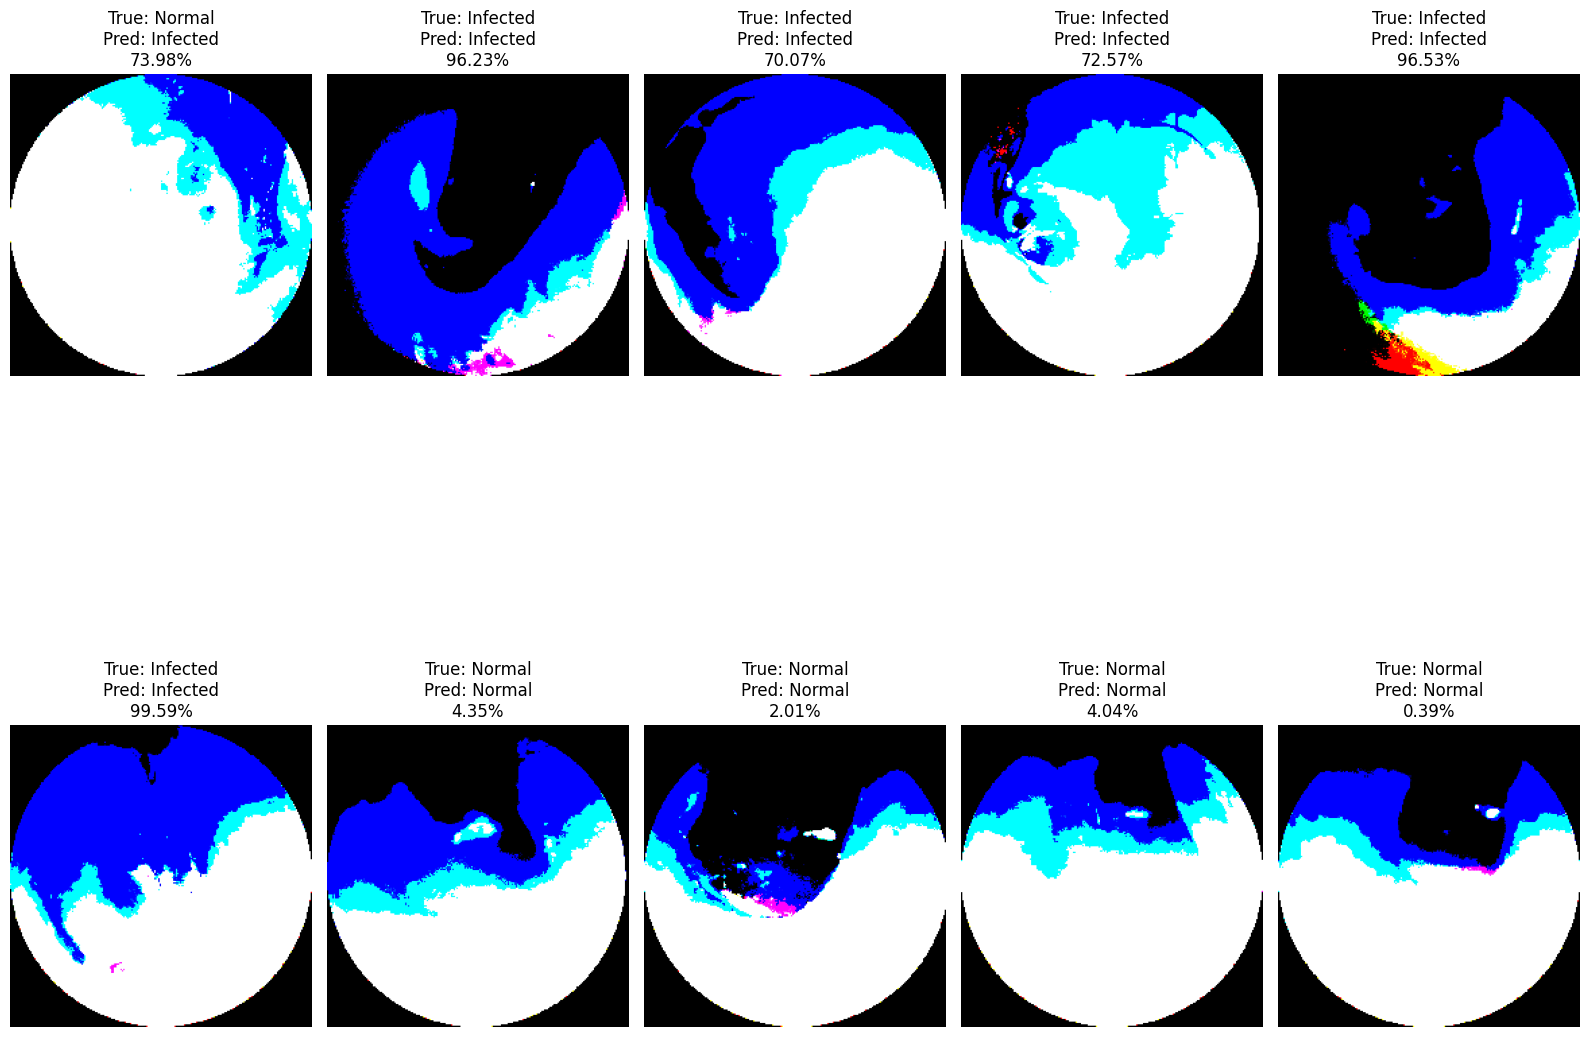

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def evaluate_random_images(model, test_generator, num_images=10):
    all_images, all_labels = [], []

    for i in range(len(test_generator)):
        images, labels = test_generator[i]
        all_images.append(images)
        all_labels.append(labels)

    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels)

    random_indexes = random.sample(range(all_images.shape[0]), num_images)

    plt.figure(figsize=(16, 16))
    for i, idx in enumerate(random_indexes):
        image = all_images[idx]
        label = all_labels[idx]

        pred_prob = model.predict(np.expand_dims(image, axis=0), verbose=0)
        pred_label = 1 if pred_prob > 0.5 else 0
        pred_percentage = pred_prob[0][0] * 100

        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(
            f"True: {'Infected' if label == 1 else 'Normal'}\n"
            f"Pred: {'Infected' if pred_label == 1 else 'Normal'}\n"
            f"{pred_percentage:.2f}%"
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()

evaluate_random_images(model, test_generator)


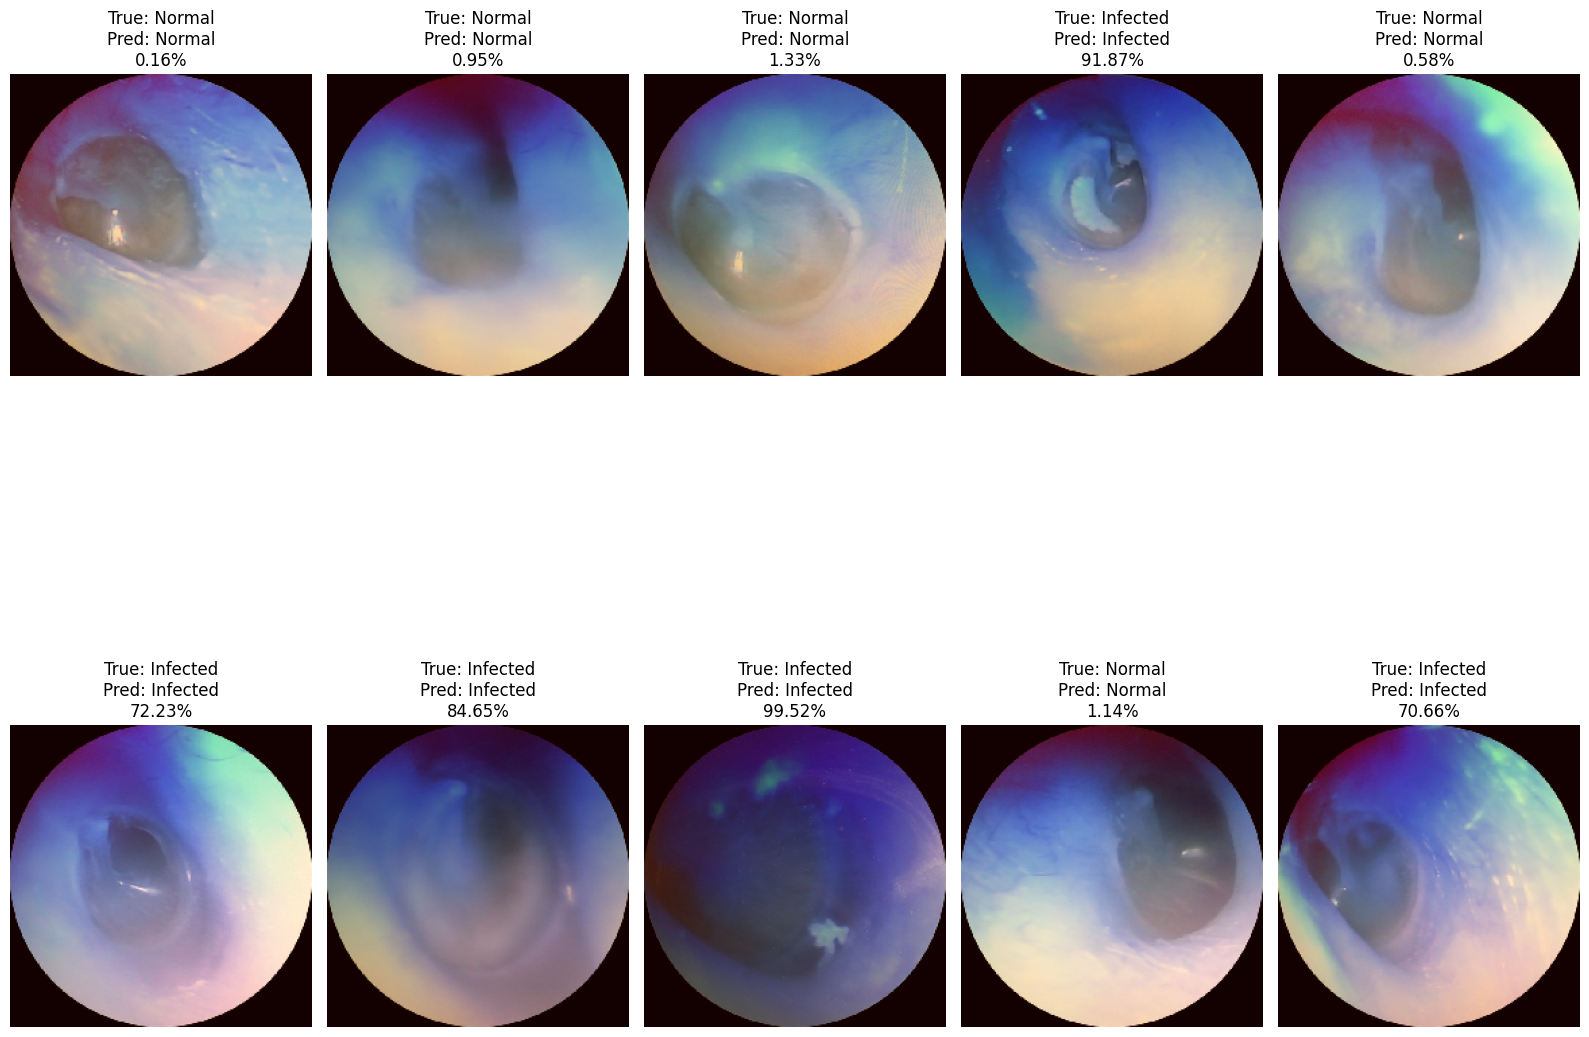

In [ ]:
def denormalize_image(image):
    image = image.copy()

    mean = [123.68, 116.779, 103.939]
    std = [1.0, 1.0, 1.0]
    image = image * std + mean
    image = np.clip(image, 0, 255) / 255.0
    return image

def evaluate_random_images(model, test_generator, num_images=10):
    all_images, all_labels = [], []

    for i in range(len(test_generator)):
        images, labels = test_generator[i]
        all_images.append(images)
        all_labels.append(labels)

    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels)

    random_indexes = random.sample(range(all_images.shape[0]), num_images)

    plt.figure(figsize=(16, 16))
    for i, idx in enumerate(random_indexes):
        image = all_images[idx]
        label = all_labels[idx]

        pred_prob = model.predict(np.expand_dims(image, axis=0), verbose=0)
        pred_label = 1 if pred_prob > 0.5 else 0
        pred_percentage = pred_prob[0][0] * 100

        display_image = denormalize_image(image)

        plt.subplot(2, 5, i + 1)
        plt.imshow(display_image)
        plt.title(
            f"True: {'Infected' if label == 1 else 'Normal'}\n"
            f"Pred: {'Infected' if pred_label == 1 else 'Normal'}\n"
            f"{pred_percentage:.2f}%"
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()

evaluate_random_images(model, test_generator)


Comprehensive visualization and evaluation of the model's performance, including accuracy and loss trends, confusion matrix, classification metrics, ROC-AUC curve, and training history summary

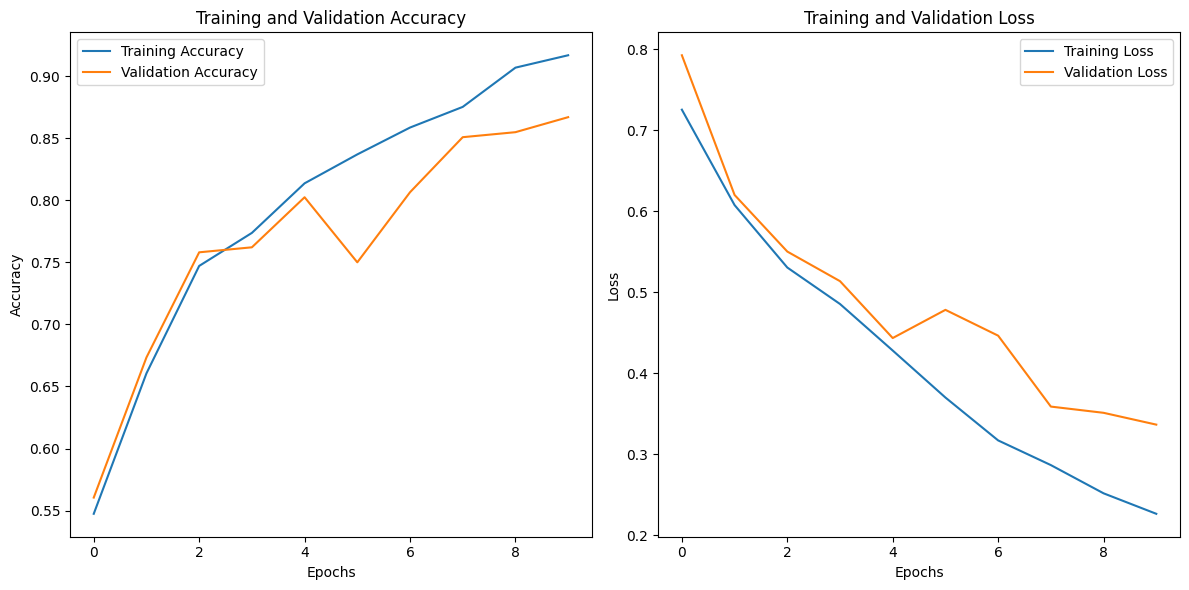

5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.8885 - loss: 0.2744
Test Loss: 0.2745
Test Accuracy: 89.61%
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step
Confusion Matrix:
[[50 31]
 [29 44]]


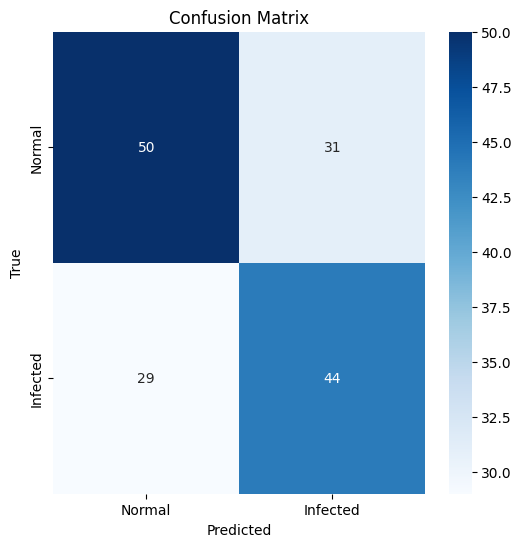

Classification Report:
              precision    recall  f1-score   support

      Normal       0.63      0.62      0.62        81
    Infected       0.59      0.60      0.59        73

    accuracy                           0.61       154
   macro avg       0.61      0.61      0.61       154
weighted avg       0.61      0.61      0.61       154

ROC AUC: 0.6100


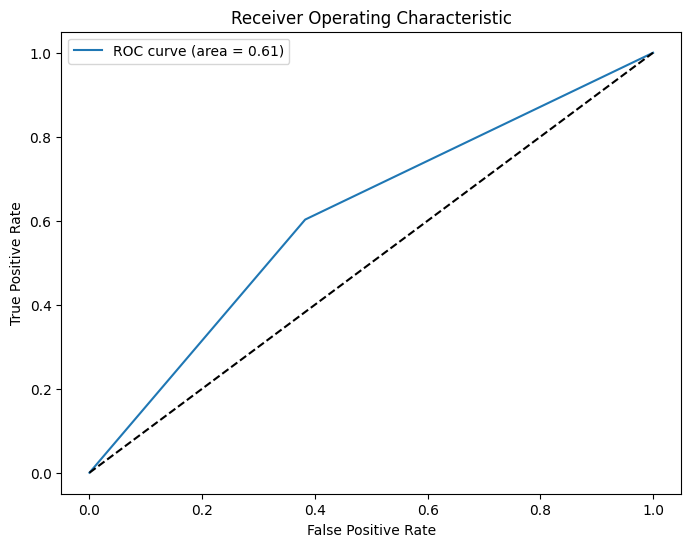

Overall Accuracy: 61.04%

Training History Summary:
Best Training Accuracy: 91.68%
Best Validation Accuracy: 86.69%
Best Training Loss: 0.2262
Best Validation Loss: 0.3363
Epoch at Best Training Accuracy: 10
Epoch at Best Validation Accuracy: 10
Early Stopping Activated: Not Available


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Plot training and validation accuracy and loss over epochs
def plot_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluate model performance on the test dataset
def evaluate_model(model, test_generator):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Generate predictions for the test dataset
    test_predictions = model.predict(test_generator)
    test_predictions = (test_predictions > 0.5).astype("int32")  # Convert to binary labels

    # Compute confusion matrix
    true_labels = test_generator.classes
    cm = confusion_matrix(true_labels, test_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Display confusion matrix as a heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Display classification report
    print("Classification Report:")
    print(classification_report(true_labels, test_predictions, target_names=['Normal', 'Infected']))

    # Calculate ROC AUC score
    try:
        roc_auc = roc_auc_score(true_labels, test_predictions)
        print(f"ROC AUC: {roc_auc:.4f}")
    except ValueError:
        print("Not enough positive samples for ROC AUC.")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='best')
    plt.show()

    # Calculate overall accuracy
    accuracy = accuracy_score(true_labels, test_predictions)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Visualize training history (accuracy and loss trends)
plot_history(history)

# Evaluate the model on the test dataset
evaluate_model(model, test_generator)

# Summarize key statistics from the training history
def summarize_training_history(history):
    print("\nTraining History Summary:")
    print(f"Best Training Accuracy: {max(history.history['accuracy']) * 100:.2f}%")
    print(f"Best Validation Accuracy: {max(history.history['val_accuracy']) * 100:.2f}%")
    print(f"Best Training Loss: {min(history.history['loss']):.4f}")
    print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
    print(f"Epoch at Best Training Accuracy: {np.argmax(history.history['accuracy']) + 1}")
    print(f"Epoch at Best Validation Accuracy: {np.argmax(history.history['val_accuracy']) + 1}")
    print(f"Early Stopping Activated: {history.history.get('early_stopping', 'Not Available')}")

# Print a summary of the training history
summarize_training_history(history)


Saving the model as tflite to make it run on limited memory server

---



In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_file = "/content/model.tflite"
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

from google.colab import files
files.download(tflite_model_file)


Saved artifact at '/tmp/tmpq3cg8kyp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_340')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137980734919056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137980734921360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137980734921744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137980734920976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137980734920592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137980734921552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137980734924816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137980734925968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137980734926352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137980734924432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1379807349

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>